## Project: Image segmentation 

Welcome back guys, Now this is the final step of your course module. Yes this is the application project. We will apply all the learned knowledge in here to create an interesting application based on image segmentation.This dataset provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator. The data was generated as part of the [Lyft Udacity Challenge](https://www.udacity.com/lyft-challenge#) . In this dataset we will try to segment the following 12 different objects from the background (classes 12+1) which includes trees, cars, roads etc.

## Tasks
- List the images and its mask respectively
- Visualize an image along with its mask
- randomly divide the train and val 
- Plot the count of pixels of each class in the dataset (Remove the background)
- Build a keras dataloader 
- train the model using FPN

## Dataset structure
The dataset is stored in the following format 
- dataA
  - CameraRGB  
  - CameraSeg
- dataB
  - CameraRGB  
  - CameraSeg
- dataC
  - CameraRGB  
  - CameraSeg
- dataD
  - CameraRGB  
  - CameraSeg
- dataD
  - CameraRGB  
  - CameraSeg
  
Each of dataA, dataB, dataC, dataD and dataE contains 1000 images each

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## 1.1 Load the data 

Unlike other machine learning problems, deep learning allows you to train your model using batches of data. So there is no requirement for loading all the data in the memory. However, we need to list all the images and its respective masks to make them available whenever they want by the algorithm and also to calculate several tasks. Our first task is to list all the images and its masks respectively. We will be using **glob** package for the same. The structure of the dataset is given above and we can formulate the same. 

In [2]:
import glob

## Reading all the images and masks
all_imgs = glob.glob("/data/grey/lyft/**/**/*.png")

## Subset all the input images
imgs = [i for i in all_imgs if "CameraRGB" in i]

## Subset all the masks
masks = [i for i in all_imgs if "CameraSeg" in i]

## Check if 1st element in img has its mask in as first element in masks list and like wise for all elements 
assert [i.rsplit("/")[-1] for i in imgs] == [i.rsplit("/")[-1] for i in masks]

## Print the number of images and masks respectively present in the data.
print(len(imgs), len(masks))

5000 5000


## 1.2 Visualize image and its respective masks

There are several ways we misunderstand the problem at our hand. The datasets come in different shape and size with various levels of bias and errors. So it is good to view the images and its respective masks to get an intution on how the data looks and what problem are we solving. This will also allow us to check if the masks for all the images are same or not. We have written several functions during our course and one such function is **plot_img_and_mask**. We will use PIL to read the image and mask respectively and plot them using this function

Note:
- Read the image and mask using PIL.
- the mask is a 3 channel image with labels present only in the first channel. So read image using pil, convert into numpy array and only select the first channel. 
- pass the pil image and numpy mask array to the function to visualize.

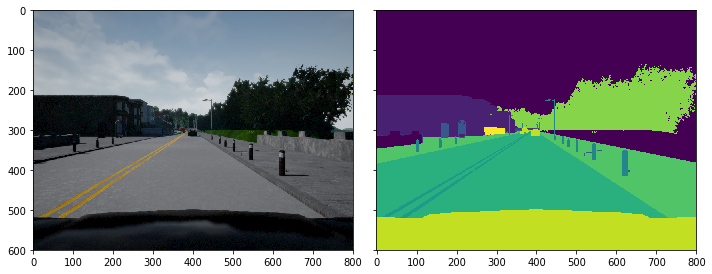

In [3]:
## Load the PIL, numpy libraries
from PIL import Image
import numpy as np 

%matplotlib inline

## Call the plot_img_and_mask 
from utils import plot_img_and_mask

## index element to read 
idx = np.random.randint(len(imgs))


pil_img = Image.open(imgs[idx])
pil_mask = Image.open(masks[idx])

mask = np.asarray(pil_mask)[:, :, 0]

plot_img_and_mask(pil_img, mask)

## 1.3 Randomly divide the dataset into train and validation

There is a problem of over-fitting in maching learning and especially deep learning since it contains millions of parameters. To make sure that the model works on external data also and is well generalized, we will split the data into train and val.

- Lets create 5000 ids using np.arange
- split the ids into train and val randomly using random package. we will keep 4000 in training and 1000 validation 
- select images and masks accordingly

In [4]:
import numpy as np 
import random

ids = np.arange(0, 5000)

## set the seed so that we will get the same shuffling
random.seed(50)
## shuffle the ids
random.shuffle(ids)

## select the first 4k as train and remaining as val
train_idx = ids[:4000]
val_idx = ids[4000:]

## train image locs and mask locs respectively
train_img_loc = [imgs[i] for i in train_idx]
train_mask_loc = [masks[i] for i in train_idx]

## val image locs and mask locs respectively
val_img_loc = [imgs[i] for i in val_idx]
val_mask_loc = [masks[i] for i in val_idx]

print(len(train_img_loc), len(train_mask_loc), len(val_img_loc), len(val_mask_loc))

4000 4000 1000 1000


## 1.4 Plot the count of pixels of each class in the dataset

We have seen various statistics to calculate in this course like pixel count, number of images each class is present etc to get an intution of the dataset and see if there is imbalance etc or not in the dataset, we will count the number of pixels each class is present for the **train_dataset**

Note:
- Read all the images and convert them to numpy array and select the first channels.
- use numpy unique with "return_counts=True" to calculate how many times each pixel occured. use these values and create a dictionary.
- plot using matplotlib

The following code will take a minute to run

In [5]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline

pixels_count = {}

for i in tqdm(train_mask_loc):
    mask = Image.open(i)
    mask = np.asarray(mask)[:, :, 0]
    label, count = np.unique(mask, return_counts=True)
    for la, c in zip(label, count):
        if la not in pixels_count.keys():
            pixels_count[la] = c 
        else:
            pixels_count[la] += c

100%|██████████| 4000/4000 [00:51<00:00, 77.51it/s]


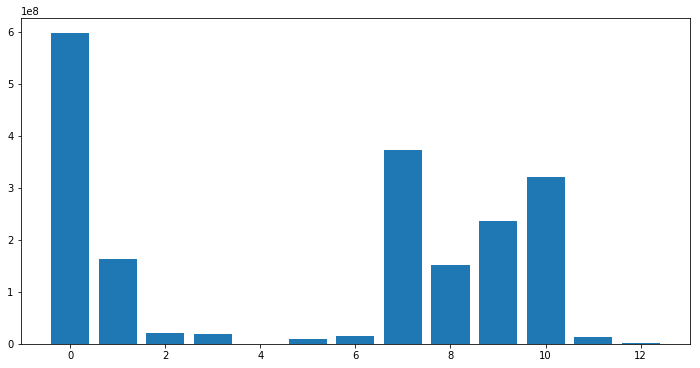

In [6]:
key_value = [(k,v) for k, v in pixels_count.items()]
labels = [i[0] for i in key_value]
counts = [i[1] for i in key_value]
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.show()

## 1.4 Build a keras dataloader 

We have already seen in the data_transformation concept on how to build a dataloader using keras. However, the data structure is slightly different in this case, so we need to make necessary modification. 

Note:
- Copy the entire CocoStuffDataGenerator and chage the list_ids to img_ids and mask_ids. 
- write custom **get_image_and_mask** such that image is (h, w, 3) and mask is (h, w) numpy array
- change list_ids to img_ids in __len__
- change __getitem__ so that **data_generation** fuction takes a list of ids.
- construct the train and val dataloader using batch_size=4, shuffle=True and remaining arguments the same. 
- Lets keep our ignore label to be zero default as here background is zero.
- Define one_hot_encoding so that we can convert (h, w) to (h, w, n_channels)
- Plot a batch of images using our skimage.util.montage used in the classroom to verify if everything is working correct or not.

In [5]:
import keras
from coco_dataloader import augmentation, random_color_augmentation
import numpy as np
import cv2


class LyftDataGenertor(keras.utils.Sequence):
    def __init__(self,
                 img_ids, 
                 mask_ids,
                 num_classes, 
                 batch_size=2, 
                 resize=512, 
                 flip = True,
                 crop = 448,
                 scales = (1., 1.25),
                 mean_bgr = (0, 0, 0),
                 pre_process = None, 
                 ignore_label = 0.,
                 color_transforms=False,
                 shuffle=False, 
                 one_hot=False):
        self.img_ids = img_ids 
        self.mask_ids = mask_ids
        self.num_classes= num_classes
        self.batch_size = batch_size
        self.resize = resize 
        self.flip = flip
        self.crop = crop
        self.scales = scales 
        self.mean_bgr = mean_bgr
        self.pre_process = pre_process
        self.ignore_label = ignore_label
        self.color_transforms = color_transforms
        self.shuffle = shuffle 
        self.one_hot = one_hot
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.img_ids) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index* self.batch_size: (index+1)* self.batch_size]
        X, y = self.data_generation(indexes)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def data_generation(self, list_ids_temp):
        imgs = []
        masks = []
        for i in list_ids_temp:
            img, mask = self.get_image_and_mask(i)
            if self.color_transforms:
                img, mask = random_color_augmentation(img, mask)
            img_aug, mask_aug = augmentation(img, mask, \
                                             resize=self.resize, \
                                             flip=self.flip, \
                                             crop_size=self.crop,\
                                             scales = self.scales,\
                                             mean_bgr = self.mean_bgr,\
                                             ignore_label = self.ignore_label)
            img_aug = np.float64(img_aug)
            if self.pre_process is not None:
                img_aug = self.pre_process(img_aug)
            if self.one_hot:
                mask_aug = self.one_hot_encoding(mask_aug, self.num_classes)
            else:
                mask_aug = np.expand_dims(mask_aug, 2)
            imgs.append(np.expand_dims(img_aug, 0))
            masks.append(np.expand_dims(mask_aug, 0))
        return np.concatenate(imgs), np.concatenate(masks)
        
    def get_image_and_mask(self, idx):
        image_path = self.img_ids[idx]
        label_path = self.mask_ids[idx]
        image = np.asarray(Image.open(image_path))
        label = np.asarray(Image.open(label_path))[:, :, 0]
        return image, label
    
    def one_hot_encoding(self, x, n_classes):
        h, w = x.shape
        y = np.zeros((h, w, n_classes))
        for i in range(1, n_classes):
            m = x.copy()
            m[m != i] = 0 
            m[m == i] = 1
            y[:, :, i] = m
        y[:, :, 0] = (x==0).astype(int)
        return y

Using TensorFlow backend.


In [6]:
train_dataloader = LyftDataGenertor(train_img_loc, train_mask_loc, num_classes=13, batch_size=9, shuffle=True)
val_dataloader = LyftDataGenertor(val_img_loc, val_mask_loc, num_classes=13, batch_size=9, shuffle=True)

In [7]:
idx = 100
X, y = train_dataloader[idx]
print(X.shape, y.shape)

(9, 448, 448, 3) (9, 448, 448, 1)


In [8]:
from skimage.util import montage # to visualize all the images at once.
import matplotlib.pyplot as plt
%matplotlib inline

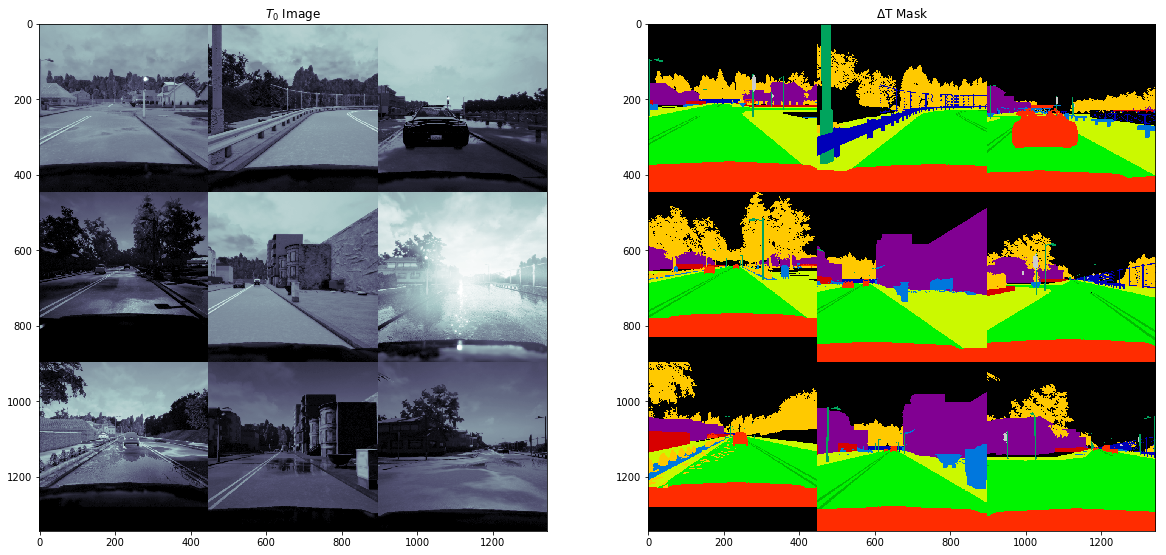

In [9]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage(y[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Mask')
plt.show()

## Train the network for 10 epochs.

Since we trained Unet in the classroom sessions, we will train LinkNet network for this problem. In general network is an hyperparameter, We have to train on all the networks and validate on the one which it is working, or may be we can ensemble and increase the performance. 

Note:
- since this is multi_class problem, lets use cce_jaccard_loss rather than bce_jaccard_loss used class room
- we will use f1_score as the metric
- Call LinkNet network with "resnet34" as backend. 
- use Adam as optimizer
- compile the model and call the dataloaders 
- train the network for 10 epochs

In [10]:
## Import the loss function
from segmentation_models.losses import cce_jaccard_loss

## Import the metric
from segmentation_models.metrics import f1_score

## Import Unet
from segmentation_models import Linknet

/mnt/nfshome1/FRACTAL/vanapalli.prakash/miniconda3/envs/keras/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [11]:
# define model
from segmentation_models.backbones import get_preprocessing
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

model = Linknet(BACKBONE, encoder_weights=None, classes=13, activation="softmax")

## Compile the model using Adam optimizer
model.compile('Adam', loss=cce_jaccard_loss, metrics=[f1_score])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
train_dataloader = LyftDataGenertor(train_img_loc, 
                                    train_mask_loc, 
                                    num_classes=13, 
                                    batch_size=4, 
                                    shuffle=True, 
                                    pre_process=preprocess_input,
                                    one_hot=True)
val_dataloader = LyftDataGenertor(val_img_loc, 
                                  val_mask_loc, 
                                  num_classes= 13, 
                                  batch_size=4, 
                                  shuffle=True, 
                                  pre_process=preprocess_input,
                                  one_hot=True)

In [13]:
## Training it for 10 epochs
model.fit_generator(generator= train_dataloader,
                    validation_data= val_dataloader,
                    use_multiprocessing= True,
                    workers= 6, 
                    epochs= 10)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
1000/1000 [==============================] - 344s 344ms/step - loss: 1.0846 - score: 0.3968 - val_loss: 1.1129 - val_score: 0.4262
Epoch 2/10
1000/1000 [==============================] - 326s 326ms/step - loss: 0.8039 - score: 0.4988 - val_loss: 0.8963 - val_score: 0.4924
Epoch 3/10
1000/1000 [==============================] - 331s 331ms/step - loss: 0.7139 - score: 0.5439 - val_loss: 0.6596 - val_score: 0.5706
Epoch 4/10
1000/1000 [==============================] - 331s 331ms/step - loss: 0.6577 - score: 0.5810 - val_loss: 0.6468 - val_score: 0.5938
Epoch 5/10
1000/1000 [==============================] - 328s 328ms/step - loss: 0.6166 - score: 0.6066 - val_loss: 0.6094 - val_score: 0.6092
Epoch 5/10
Epoch 6/10
1000/1000 [==============================] - 335s 335ms/step - loss: 0.5769 - score: 0.6283 - val_loss: 0.6207 - val_score: 0.6170
Epoch 7/10


- We reached a val f1_score of 67% in 10 epochs. We haven't used imagenet pretrained weights. Try to change encoder_weights="imagenet" and you should see this increasing much more.

# THE END. Thank you very much